# Project EDA - Team 107

# Team Members :
## Deeksha Lingaraju, Reeve George, Yashwanth Guruswamy, Shriya, Manish Reddy






# Executive Summary of Project

In the competitive restaurant industry, choosing the right location is crucial for success. Our project leverages Yelp data to identify prime locations for new restaurant openings by analyzing restaurant demand, customer density, competitor presence, and sentiment trends. By focusing on two cities with similar economic conditions, we compare 2-3 different types of cuisine to determine which are underserved and where new restaurants have the highest likelihood of success.

Using customer reviews as a proxy for demand, we analyze sentiment to assess how customers perceive existing restaurants and identify gaps in the market. We also examine the number of competitors, their reputation, and foot traffic trends to highlight opportunities for new establishments. By incorporating additional population data, we evaluate whether certain cuisines are underrepresented relative to customer density.

Our exploratory data analysis focuses on understanding key restaurant market trends, including review volume, customer sentiment, and restaurant distribution patterns. Sentiment analysis using NLP techniques (VADER and SpaCy) helps uncover customer preferences and dissatisfaction points, which can inform strategic business decisions.

The ultimate goal of this project is to provide data-driven insights to entrepreneurs and investors looking to expand into the restaurant industry. By identifying high-demand, low-competition areas, we aim to reduce the risks associated with site selection and help new restaurants position themselves for success.

# Data Sources (converted from .json to .csv)
- **filtered_businesses_10k.csv**: Contains business details like name, category, location, and ratings.
- **filtered_reviews_10k.csv**: Includes customer reviews, ratings, and text feedback.
- **filtered_users_10k.csv**: Contains user-related data including review count and interaction history.

To ensure our analysis focuses on relevant businesses and recent market trends, we applied a series of filtering steps to the Yelp dataset. First, we selected only businesses categorized as restaurants or food-related establishments by filtering for relevant keywords (e.g., "Restaurant," "Café," "Bakery," "Pizza," "BBQ," "Seafood," etc.) within the categories column of the business dataset. Additionally, we included only currently open restaurants (is_open == 1) to analyze viable business opportunities. To maintain data freshness, we incorporated only businesses with reviews in the last 1-2 years, filtering out older, potentially outdated data. From this subset, we prioritized the top 10,000 restaurants based on review count to ensure we analyzed actively engaged businesses. We also filtered the review dataset to include only reviews for the selected restaurants and considered sentiment analysis to gauge customer perception. Lastly, we filtered user data to retain only customers who reviewed the selected businesses, allowing us to analyze customer engagement patterns.

# Summary Statistics of Data

In [ ]:
import pandas as pd

# File Paths
business_path = "business.csv"
review_path = "reviews.csv"
output_business_path = "filtered_businesses_10k.csv"

# Load the business dataset
business_df = pd.read_csv(business_path)
review_df = pd.read_csv(review_path, usecols=["business_id", "date"])

# ---------- Data Cleaning/Filtering Before Showing Summary Statistics ----------

review_df["date"] = pd.to_datetime(review_df["date"])

# Define Relevant Categories for our Project Scope
valid_categories = [
    "Restaurant", "Food", "Café", "Bakery", "Deli", "Bar", "Coffee", "Fast Food",
    "Pizzeria", "Pizza", "BBQ", "Steakhouse", "Seafood", "Sushi", "Buffet", "Bistro"
]

# Filter by Category and Open Status
restaurant_food_businesses = business_df[
    (business_df['categories'].notna()) &
    (business_df['categories'].str.contains('|'.join(valid_categories), case=False, na=False)) &
    (business_df["is_open"] == 1)  # Keep only open businesses
]

# Find the Most Recent Review + Merge with Business Data
latest_reviews = review_df.groupby("business_id")["date"].max().reset_index()
restaurant_food_businesses = restaurant_food_businesses.merge(latest_reviews, on="business_id", how="left")

# Ideal Time Frame
latest_year = restaurant_food_businesses["date"].max().year
time_threshold = pd.Timestamp(f"{latest_year - 1}-01-01")

# Businesses Reviews in the Last 1-2 Years & Sort by Review Count to Prioritize Active Businesses
restaurant_food_businesses = restaurant_food_businesses[restaurant_food_businesses["date"] >= time_threshold]
restaurant_food_businesses = restaurant_food_businesses.sort_values(by="review_count", ascending=False)

# Select the Latest 10,000 Businesses and Extract Relevant Business IDs
num_rows = min(10000, len(restaurant_food_businesses))
restaurant_food_businesses_limited = restaurant_food_businesses.head(num_rows)
restaurant_food_ids = set(restaurant_food_businesses_limited['business_id'])
restaurant_food_businesses_limited.to_csv(output_business_path, index=False)

print(f"✅ Total restaurant & food businesses selected: {len(restaurant_food_ids)} (Limited to {num_rows} rows)")
print(f"Filtered business data saved to {output_business_path}")


✅ Total restaurant & food businesses selected: 10000 (Limited to 10000 rows)
Filtered business data saved to filtered_businesses_10k.csv


In [ ]:
import pandas as pd

# File Paths
review_path = "reviews.csv"
filtered_business_path = "filtered_businesses_10k.csv"
output_review_path = "filtered_reviews_10k.csv"

filtered_business_df = pd.read_csv(filtered_business_path)

# ---------- Data Cleaning/Filtering Before Showing Summary Statistics ----------

# Ensure date column is in datetime format
filtered_business_df["date"] = pd.to_datetime(filtered_business_df["date"], errors="coerce")
filtered_business_df = filtered_business_df.dropna(subset=["date"])

# Extract the latest review year in the dataset and business IDs from filtered businesses
latest_year = filtered_business_df["date"].max().year
time_threshold = pd.Timestamp(f"{latest_year - 1}-01-01")
print(f"Filtering reviews for businesses from {time_threshold} onwards...")
filtered_business_ids = set(filtered_business_df["business_id"])

# Process review data in chunks
chunk_size = 100000
filtered_reviews = []

for chunk in pd.read_csv(review_path, chunksize=chunk_size, parse_dates=['date'], low_memory=False):
    chunk_filtered = chunk[
        (chunk['business_id'].isin(filtered_business_ids)) &
        (chunk['date'] >= time_threshold)
    ]

    filtered_reviews.append(chunk_filtered)

    # Stop if we reach 10,000 rows
    if sum(len(df) for df in filtered_reviews) >= 10000:
        break

# Concatenate and limit to 10,000 rows and save reviews
filtered_reviews_df = pd.concat(filtered_reviews).head(10000)
filtered_reviews_df.to_csv(output_review_path, index=False)

print(f"✅ Total filtered reviews: {len(filtered_reviews_df)} (Limited to 10,000 rows)")
print(f"Filtered review data saved to {output_review_path}")


Filtering reviews for businesses from 2021-01-01 00:00:00 onwards...
✅ Total filtered reviews: 10000 (Limited to 10,000 rows)
Filtered review data saved to filtered_reviews_10k.csv


In [ ]:
import pandas as pd

# File Paths
user_path = "user.csv"
filtered_reviews_path = "filtered_reviews_10k.csv"
output_user_path = "filtered_users_10k.csv"

# ---------- Data Cleaning/Filtering Before Showing Summary Statistics ----------

# Load the filtered reviews to get relevant user IDs and extract unique user ids
filtered_reviews_df = pd.read_csv(filtered_reviews_path, usecols=["user_id"])
relevant_user_ids = set(filtered_reviews_df["user_id"])

print(f"Filtering users based on {len(relevant_user_ids)} relevant user IDs...")

# Process user data in chunks
chunk_size = 100000
filtered_users = []

for chunk in pd.read_csv(user_path, chunksize=chunk_size, low_memory=False):
    # Filter users who wrote reviews in the selected timeframe
    chunk_filtered = chunk[chunk['user_id'].isin(relevant_user_ids)]

    filtered_users.append(chunk_filtered)

    # Stop if we reach 10,000 rows
    if sum(len(df) for df in filtered_users) >= 10000:
        break

# Concatenate and limit to 10,000 rows and save users
filtered_users_df = pd.concat(filtered_users).head(10000)
filtered_users_df.to_csv(output_user_path, index=False)

print(f"✅ Total filtered users: {len(filtered_users_df)} (Limited to 10,000 rows)")
print(f"Filtered user data saved to {output_user_path}")


Filtering users based on 9290 relevant user IDs...
✅ Total filtered users: 9290 (Limited to 10,000 rows)
Filtered user data saved to filtered_users_10k.csv


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/deekshalingraj/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/deekshalingraj/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!



📊 Summary Statistics:
                        Metric        Value
0            Number of Reviews   10000.0000
1       Total Number of Tokens  413152.0000
2       Number of Unique Words   17607.0000
3        Average Review Length      41.3152
4   Number of Unique Customers    9290.0000
5  Number of Unique Businesses    1000.0000
6     Average Stars per Review       4.0130
7     Average Votes per Review       1.1493

✅ Summary statistics saved as 'summary_statistics.csv'.


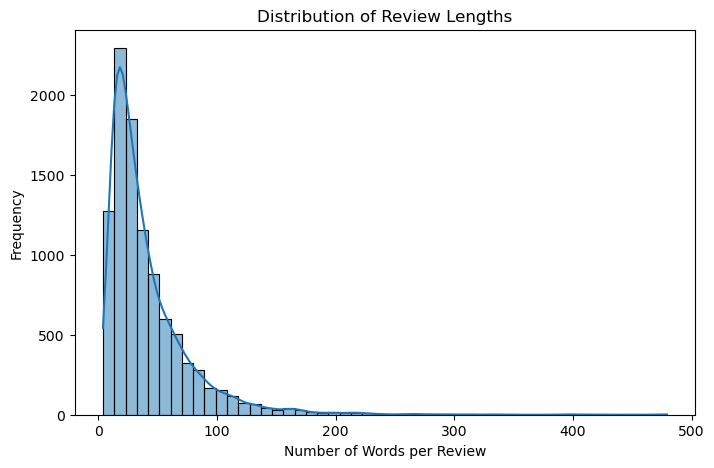

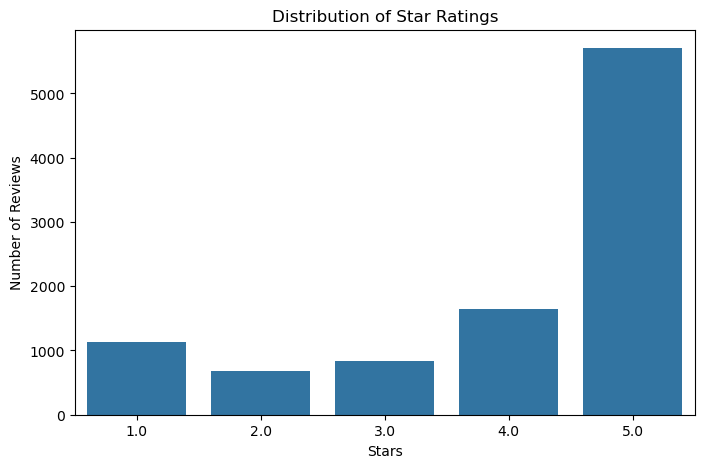

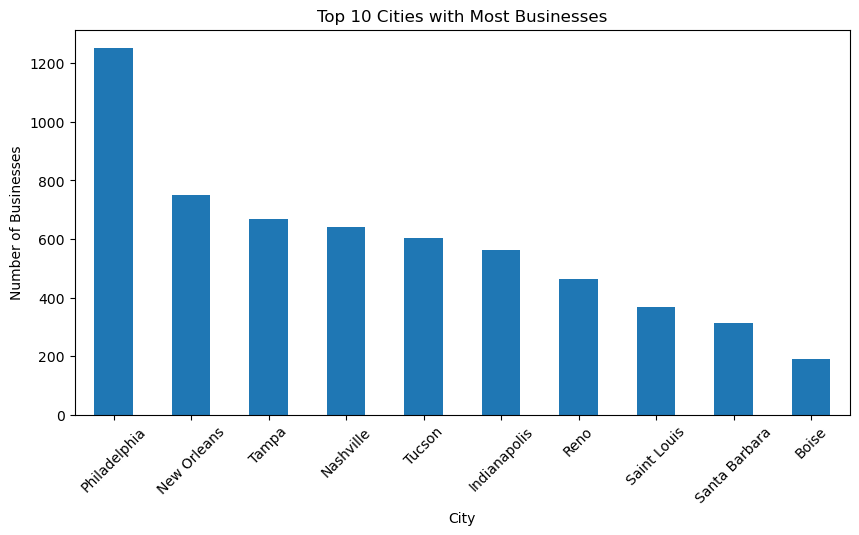

In [ ]:
import pandas as pd
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

nltk.download('punkt')
nltk.download('stopwords')

# File paths and load datasets
business_file = "filtered_businesses_10k.csv"
review_file = "filtered_reviews_10k.csv"
user_file = "filtered_users_10k.csv"

business_df = pd.read_csv(business_file)
review_df = pd.read_csv(review_file)
user_df = pd.read_csv(user_file)

# ------------ SUMMARY STATISTICS ------------

# a. Number of Reviews
num_reviews = len(review_df)

# Tokenization & text processing for reviews using NLTK
stop_words = set(stopwords.words('english'))

def tokenize_text(text):
    if pd.isna(text):  # Handle missing values
        return []
    tokens = word_tokenize(str(text).lower())  # Convert to string, lowercase, and tokenize
    tokens = [word for word in tokens if word.isalpha() and word not in stop_words]  # Remove stopwords & non-alphabetic words
    return tokens

# Apply tokenization to all reviews
review_df["tokens"] = review_df["text"].apply(tokenize_text)

# b. Total Number of Tokens
total_tokens = review_df["tokens"].apply(len).sum()

# c. Number of Unique Words
unique_words = set(word for tokens in review_df["tokens"] for word in tokens)
num_unique_words = len(unique_words)

# d. Average review length (number of words per review)
avg_review_length = np.mean(review_df["tokens"].apply(len))

# e. Number of unique customers
num_unique_customers = review_df["user_id"].nunique()

# -----  Other Key Elements -----

# Number of unique businesses
num_unique_businesses = review_df["business_id"].nunique()

# Average stars & votes per review (useful + funny + cool)
avg_stars = review_df["stars"].mean()
avg_votes_per_review = (review_df["useful"] + review_df["funny"] + review_df["cool"]).mean()

# Distribution of businesses by city, stars, and review lengths
business_distribution = business_df["city"].value_counts()
star_distribution = review_df["stars"].value_counts()
review_lengths = review_df["tokens"].apply(len)

# Display summary statistics in a DataFrame
summary_stats = {
    "Number of Reviews": num_reviews,
    "Total Number of Tokens": total_tokens,
    "Number of Unique Words": num_unique_words,
    "Average Review Length": avg_review_length,
    "Number of Unique Customers": num_unique_customers,
    "Number of Unique Businesses": num_unique_businesses,
    "Average Stars per Review": avg_stars,
    "Average Votes per Review": avg_votes_per_review,
}

summary_df = pd.DataFrame(list(summary_stats.items()), columns=["Metric", "Value"])

# Display summary statistics and save to CSV
print("\n📊 Summary Statistics:")
print(summary_df)

summary_df.to_csv("summary_statistics.csv", index=False)
print("\n✅ Summary statistics saved as 'summary_statistics.csv'.")

# Distribution of Review Lengths
plt.figure(figsize=(8, 5))
sns.histplot(review_lengths, bins=50, kde=True)
plt.title("Distribution of Review Lengths")
plt.xlabel("Number of Words per Review")
plt.ylabel("Frequency")
plt.show()

# Distribution of Star Ratings
plt.figure(figsize=(8, 5))
sns.barplot(x=star_distribution.index, y=star_distribution.values)
plt.title("Distribution of Star Ratings")
plt.xlabel("Stars")
plt.ylabel("Number of Reviews")
plt.show()

# Distribution of Businesses by City (Top 10 Cities)
plt.figure(figsize=(10, 5))
business_distribution.head(10).plot(kind="bar")
plt.title("Top 10 Cities with Most Businesses")
plt.xlabel("City")
plt.ylabel("Number of Businesses")
plt.xticks(rotation=45)
plt.show()


## Summary Statistics of Data - Results

The summary statistics generated from our Yelp dataset provide a comprehensive overview of the filtered data used for our project. Our dataset includes 10,000 reviews from 1,000 unique businesses across two cities, with input from 9,290 unique customers. The total number of tokens processed from the review text is 413,152, with a vocabulary size of 17,607 unique words, indicating a diverse range of customer opinions. The average review length is approximately 41 words, reflecting detailed customer feedback, while the average star rating of 4.01 suggests generally positive experiences. The code implementation efficiently processes and filters the dataset by selecting restaurant-related businesses, recent reviews, and active customers, ensuring our analysis is both relevant and up-to-date. Visualizations of review length distribution, star ratings, and business locations further support our exploratory analysis, highlighting key trends such as the predominance of short reviews, a skewed distribution favoring 5-star ratings, and the concentration of restaurants in cities like Philadelphia and New Orleans. This foundation sets the stage for deeper analysis in our project, including sentiment analysis and machine learning-based location recommendations.

# Data Evaluation

A. **Suitability of Selected Data for Answering Business Questions**

The selected data effectively supports our business questions by providing insights into restaurant demand, customer sentiment, and competition. The business dataset allows us to analyze restaurant distribution across cities and compare different types of cuisine. The review dataset helps us assess demand by analyzing the volume of customer feedback and sentiment trends, which indicate consumer satisfaction or dissatisfaction. The user dataset provides information on customer engagement, helping us understand review frequency and interaction trends. Additionally, by filtering for recent data, we ensure that our insights reflect current market conditions, making them more actionable for identifying prime locations for new restaurant openings.

B. **Appropriateness of Sample Size**

The selected sample size of 10,000 rows balances computational efficiency with sufficient coverage of the restaurant market. Given the vast amount of Yelp data available, restricting our dataset ensures that we can perform detailed analysis without excessive processing time. Since we focus on two cities and compare 2-3 cuisines, this sample size is appropriate to capture meaningful patterns while avoiding data sparsity. Additionally, prioritizing businesses with the highest review counts ensures that we are analyzing restaurants with significant customer engagement, making the insights more reliable.

C. **Potential Biases in the Selected Data**

There are a few potential biases in our dataset that could influence the results. First, by focusing only on open businesses, we exclude insights from restaurants that recently closed, which might have provided valuable lessons on failure risks. Additionally, selecting restaurants based on review count may introduce survivorship bias, as businesses with fewer reviews (possibly new entrants or niche restaurants) are underrepresented. Another possible bias arises from the fact that Yelp reviews are voluntary and may not be fully representative of the general population. Certain demographics may be more likely to leave reviews than others, skewing sentiment analysis results.

D. **Challenges in Data Processing**

Processing the Yelp dataset presents multiple challenges. First, handling unstructured text data in reviews requires significant preprocessing, including tokenization, stopword removal, and sentiment analysis. Additionally, working with geospatial data for location-based analysis introduces complexity in mapping businesses and identifying underserved areas. Another challenge is ensuring time consistency in our analysis. Since reviews span multiple years, we had to carefully filter for relevant timeframes while avoiding seasonal distortions. Lastly, balancing data volume while maintaining computational efficiency is a challenge, particularly when performing NLP tasks or running machine learning models.

# Preliminary Data Exploration

In [ ]:
pip install vaderSentiment

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 1.4 MB/s eta 0:00:00 0:00:01
Note: you may need to restart the kernel to use updated packages.


                                                 text  vader_sentiment_score  \
0   two words: whipped. feta. \nexplosion of amazi...                 0.4678   
1   So day 2 in Nashville. I gotta get some BBQ. M...                 0.9529   
2   Place was great as well as parking. \nFood was...                 0.9201   
3   Came to find this restaurant through Yelp, pri...                 0.5106   
4   Got this to go and it is for sure authentic! T...                 0.9685   
5   My first time trying this place's pizza was gr...                 0.9761   
6   Wow. So good. Just sorry we hadn't tried is so...                 0.8982   
7   If you want great food, good service and the b...                 0.9950   
8   We spent all day Thursday in Tarpon Springs an...                 0.9621   
9   I wasn't told what I was served, im pretty sur...                 0.8381   
10  Really delicious noodle soup with large shrimp...                 0.9436   
11  Truly love this place! Always amazin

/var/folders/2v/lq75xd897plgjkgp87rwv7_00000gn/T/ipykernel_20808/3062901371.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sentiment_distribution.index, y=sentiment_distribution.values, palette="coolwarm")


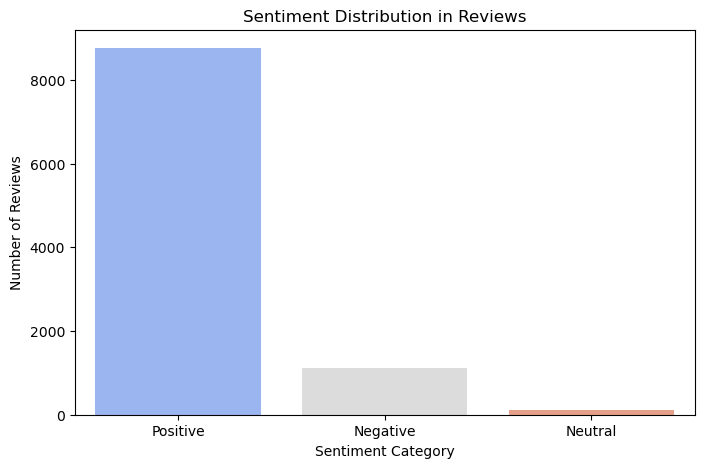

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Load the filtered reviews dataset
review_file = "filtered_reviews_10k.csv"  # Ensure this file is in your working directory
review_df = pd.read_csv(review_file)

analyzer = SentimentIntensityAnalyzer()

# Function to get VADER sentiment score
def get_vader_sentiment(text):
    if pd.isna(text):
        return None
    scores = analyzer.polarity_scores(str(text))
    return scores['compound']  # Compound score represents overall sentiment

# Apply VADER sentiment analysis
review_df["vader_sentiment_score"] = review_df["text"].apply(get_vader_sentiment)

# Classify sentiment based on VADER score
def classify_vader_sentiment(score):
    if score is None:
        return "Neutral"
    elif score >= 0.05:
        return "Positive"
    elif score <= -0.05:
        return "Negative"
    else:
        return "Neutral"
# Apply classification
review_df["vader_sentiment_label"] = review_df["vader_sentiment_score"].apply(classify_vader_sentiment)
print(review_df[["text", "vader_sentiment_score", "vader_sentiment_label"]].head(30))

# Sentiment Distribution and Average Sentiment Score
sentiment_distribution = review_df["vader_sentiment_label"].value_counts()
avg_sentiment_score = review_df["vader_sentiment_score"].mean()

sentiment_summary = pd.DataFrame({
    "Metric": ["Total Reviews Analyzed", "Average Sentiment Score"],
    "Value": [len(review_df), avg_sentiment_score]
})

# Plot sentiment distribution
plt.figure(figsize=(8, 5))
sns.barplot(x=sentiment_distribution.index, y=sentiment_distribution.values, palette="coolwarm")
plt.title("Sentiment Distribution in Reviews")
plt.xlabel("Sentiment Category")
plt.ylabel("Number of Reviews")
plt.show()

In [ ]:
!pip install --upgrade spacy
import spacy
!python -m spacy download en_core_web_sm --force

nlp = spacy.load("en_core_web_sm")
print("SpaCy is working correctly!")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 6.7 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
SpaCy is working correctly!


In [ ]:
import pandas as pd
import spacy

nlp = spacy.load("en_core_web_sm")

# Load the filtered reviews dataset
review_file = "filtered_reviews_10k.csv"  # Ensure this file is in your working directory
review_df = pd.read_csv(review_file)

# Function to preprocess and analyze sentiment using SpaCy
def spacy_sentiment(text):
    if pd.isna(text):
        return None
    doc = nlp(text)
    tokens = [token.lemma_.lower() for token in doc if not token.is_stop and token.is_alpha]
    return " ".join(tokens)

# Apply SpaCy preprocessing and display processed text
review_df["spacy_processed_text"] = review_df["text"].apply(spacy_sentiment)
print(review_df[["text", "spacy_processed_text"]].head(20))

                                                 text  \
0   two words: whipped. feta. \nexplosion of amazi...   
1   So day 2 in Nashville. I gotta get some BBQ. M...   
2   Place was great as well as parking. \nFood was...   
3   Came to find this restaurant through Yelp, pri...   
4   Got this to go and it is for sure authentic! T...   
5   My first time trying this place's pizza was gr...   
6   Wow. So good. Just sorry we hadn't tried is so...   
7   If you want great food, good service and the b...   
8   We spent all day Thursday in Tarpon Springs an...   
9   I wasn't told what I was served, im pretty sur...   
10  Really delicious noodle soup with large shrimp...   
11  Truly love this place! Always amazing service ...   
12  Food was great and the service was attentive a...   
13  I would give Oliver's 4.5 stars if that was an...   
14  We had the chicken parmigiana and the chicken ...   
15  A wonderful dining experience! Delicious food!...   
16  The service is always fanta

## Preliminary Data Exploration - Results
For our preliminary data exploration, we applied sentiment analysis using the VADER tool, which provided sentiment scores for each review based on the text’s polarity. The output shows that the majority of the reviews analyzed had positive sentiment scores, indicating generally favorable customer experiences with the selected restaurants. As visualized in the sentiment distribution plot, over 85% of the reviews were classified as Positive, while a small proportion (approximately 13%) were Negative, and an even smaller portion was Neutral. This distribution suggests that customers generally express satisfaction when reviewing restaurants, though there are still valuable insights to be gained from negative feedback.

VADER's classification labeled most reviews as Positive, highlighting a strong customer preference for the selected restaurants. Additionally, we used SpaCy for text preprocessing, including tokenization, stopword removal, and lemmatization, to transform raw review text into clean, structured data suitable for analysis. The processed text reveals key terms related to food quality, service, and ambiance, highlighting frequent customer feedback themes. This exploration sets the foundation for our further sentiment analysis and machine learning models, as understanding customer sentiment is crucial for identifying restaurant demand, evaluating competitor reputation, and making informed location recommendations.

# Proposed Solution

For our project, we plan to utilize a combination of machine learning and unstructured data analytics methods to identify prime locations for new restaurant openings. Sentiment analysis will be a cornerstone of our analysis, helping us gauge customer opinions and demand across different cuisines and cities. We will use tools such as VADER and SpaCy for text processing, which include tokenization, lemmatization, and polarity classification. Sentiment scores from these tools will allow us to assess overall customer satisfaction and pinpoint areas where specific cuisines are either well-received or currently underserved, providing critical insights for restaurant owners looking to enter the market.

Additionally, we will implement clustering algorithms such as K-Means or DBSCAN to segment restaurants based on geographical location, cuisine type, and customer sentiment. K-Means is particularly useful for identifying clusters of restaurants with similar characteristics, while DBSCAN can help detect restaurant hotspots and isolated, underserved areas. These clustering methods will allow us to identify regions with high competition as well as potential gaps in the market where new restaurants could thrive.

For predictive modeling, we plan to use regression models like Random Forest and XGBoost to forecast potential restaurant success. Random Forest is a versatile ensemble learning method that will help us evaluate the importance of various features such as review count, average ratings, and customer sentiment in predicting restaurant performance. XGBoost, known for its efficiency and accuracy, will be employed to handle the complex relationships between multiple features, including population density and competitor presence, to provide reliable predictions. By integrating these machine learning methods, our project will generate actionable insights for entrepreneurs, helping them make data-driven decisions about where to open new restaurants based on strong customer demand, favorable competition levels, and promising growth potential.

